##  Exercise Session 4: Regression and Classification

**Total points (10 + 1 Bonus Point)**

In this exercise, you'll build upon the knowledge you've learned last week. First, you'll revisit on performing linear regression using statsmodels. Following that, you'll delve into the identification of outliers, leverage points, and influential points. Next, you'll employ the bird dataset (under Exercises/Session_04 folder on OLAT) to conduct linear regression on multiple variables (Multiple linear regression), utilizing the machine learning library *scikit-learn* (https://scikit-learn.org) and the statistical visualization library *seaborn* (https://seaborn.pydata.org). Lastly, you'll explore the application of Linear Discriminant Analysis (LDA) for tackling more complex classification problems.

**Main topics**: 
- Regression: linear regression, outliers, leverage points, multilinear regression, logistic regression
- Classification: Linear Discriminant Analysis

The deadline to submit your solutions to this exercise is **next Tuesday (19.03.2024) by the end of the day (23:59 CET)**. 

Please submit your solutions in python notebook format and rename the file as "**Exercise_04_FirstName_LastName.ipynb**"

In [21]:
## Install the required libraries if you don't have them installed
# ! pip install seaborn
# ! pip install statsmodels
# ! pip install scikit-learn

## 1 Regression
### 1.1 Linear Regression and influential plot

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as sma # 
from sklearn import (linear_model, datasets, metrics, discriminant_analysis)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# intialise data and fit a linear model
np.random.seed(0)
x1 = np.sort(np.random.normal(20, 3, 20)) # 20 random numbers from a normal distribution with mean 20 and standard deviation 3
y0 = 5 + 0.5 * x1
y1 = 5 + 0.5 * x1 + np.random.normal(0, 1, 20) # add noise to the data

# by default `intercept` is not included in fitting the model. We explicitly add it here.
lm = sma.OLS(y1, sma.add_constant(x1)).fit() # Fit regression model, OLS stands for Ordinary Least Squares
print("The rsquared values is " + str(lm.rsquared)) # rsquared value represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.
#print(lm.summary()) # Print the summary of the model

The rsquared values is 0.5811883958393314


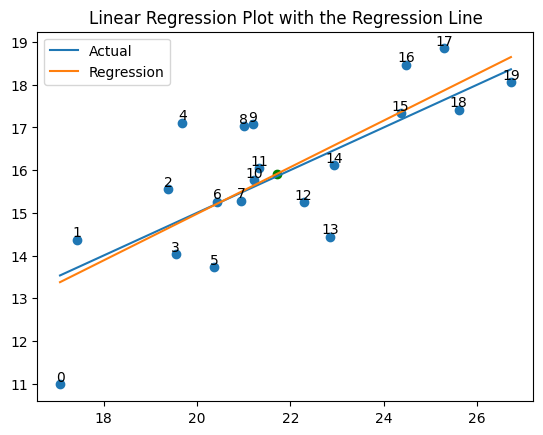

In [4]:
# Plot the data and the regression line
plt.scatter(x1, y1) 
plt.scatter(np.mean(x1), np.mean(y1), color = "green") # plot the mean of the x and y values
for i, (x, y) in enumerate(zip(x1, y1)): 
    plt.text(x, y, i, ha='center', va='bottom') 
plt.plot(x1, y0, label = "Actual") 
plt.plot(x1, lm.predict(), label = "Regression") 
plt.title("Linear Regression Plot with the Regression Line") 
plt.legend()

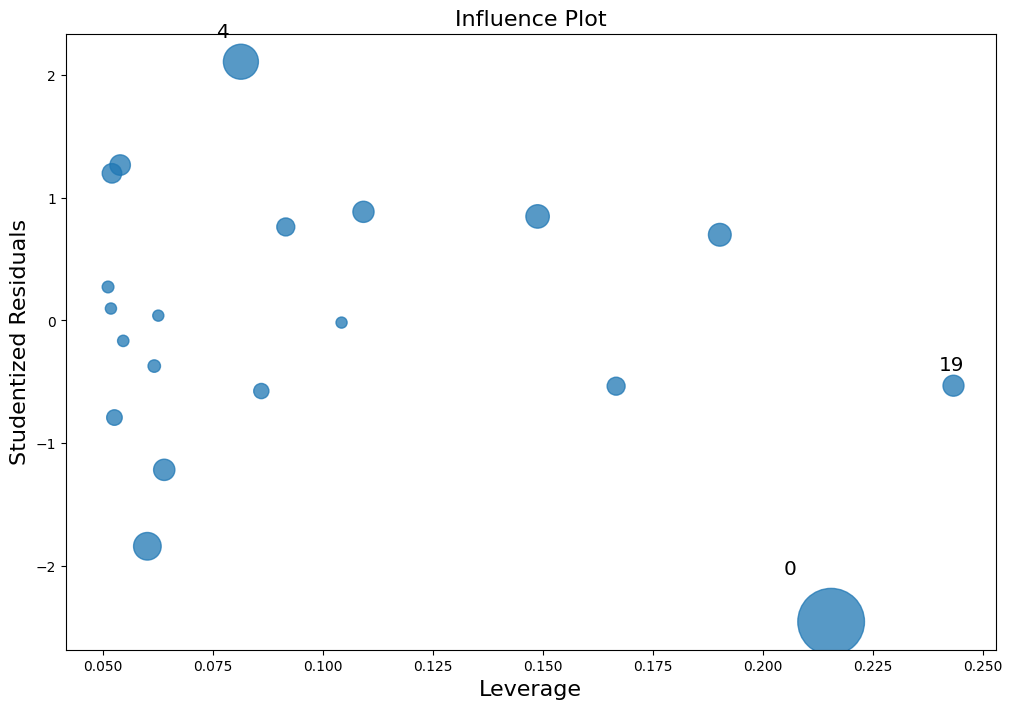

In [5]:
# plot influence plot
fig, ax = plt.subplots(figsize=(12,8))
fig = sma.graphics.influence_plot(lm, alpha=0.05, ax=ax, criterion="cooks") # Influence plot: Observations with high leverage, or large residuals will be labeled in the plot to show potential influence points.

# y-axis represents the studentized residuals. Studentized residuals are the residuals divided by their estimated standard deviation. 
# These residuals are often used in diagnostic plots to assess the fit of a regression model.

**Observations**:
1. High rsquared value
2. Since Y axis represents the residuals, point 0 is an outlier
3. Points 0 and 19 are high leverage data points

### 1.2 Linear Regression and Leverage Statistics

In [6]:
# initilze the random number generator
n = 100
x = np.linspace(0, 10, n)
x[-1] = 20
x[-2] = 18

eps = np.random.normal(0, 0.5, size=x.shape)
y = 0.5*x + 2. + eps
y[-1] = 10
y[10] = 5
y[50] = 1

df = pd.DataFrame({'x': x, 'y': y})
df.to_csv('data/numbers.csv', index=False)

**Task 1 (1 point)**. By loading x and y values from numbers csv file, perform a linear regression with y~x (the dependent variable y is modeled as a function of the independent variable x).

In [8]:
# DONE: Load the `numers.csv` file
df = pd.read_csv("/Users/merterol/Desktop/VSCode/uzh/Computational Science/ESC403/Exercise 3/data/numbers.csv")

In [11]:
# DONE: Perform a linear regression with y ~ x
from sklearn.linear_model import LinearRegression
x = df["x"].values.reshape(-1, 1)
y = df["y"].values.reshape(-1, 1)
model = LinearRegression().fit(x, y)

print("R^2 is " + str(model.score(x, y)))
print("coefficient is " + str(model.coef_))
print("intercept is " + str(model.intercept_))


R^2 is 0.8668823380534423
coefficient is [[0.50167818]]
intercept is [1.99696924]


**Task 2 (1 point)**: Calculate the leverage statistics. Plot the leverage vs the residuals and identify any outliers and leverage points. Are there any influential points?

*Hint 1*: Take a look at the [get_influence()](https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLSResults.get_influence.html#statsmodels.regression.linear_model.OLSResults.get_influence)

*Hint 2*: leverage and studentized_residuals can be obtained from the `influence` object

mean Leverage: 0.009999999999999998
std Leverage: 0.014087079647833263


Text(0.5, 1.0, 'Leverage vs Studentized Residuals')

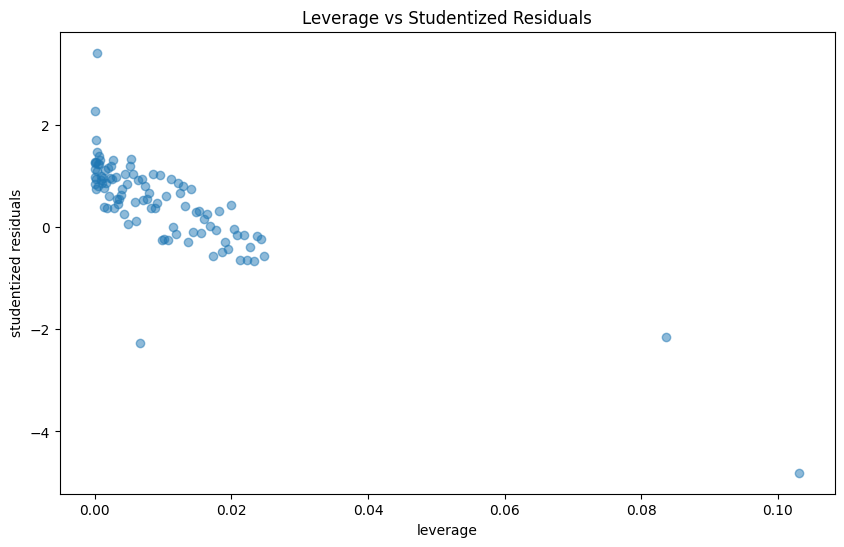

In [23]:
sma_model = sma.OLS(y, x).fit()
infl = sma_model.get_influence()

leverage = infl.hat_matrix_diag
resid_student = infl.resid_studentized_external
print("mean Leverage: " + str(np.mean(leverage)))
print("std Leverage: " + str(np.std(leverage)))

plt.figure(figsize=(10, 6))
plt.scatter(leverage, resid_student, alpha=0.5)
plt.xlabel("leverage")
plt.ylabel("studentized residuals")
plt.title("Leverage vs Studentized Residuals")


I would consider the two points on the far lower right of the graph to be influenctial

**Task 3 (bonus point)**:Calculate the leverage statistics with the formula from the lecture: $h_i = \frac{1}{n} + \frac{1}{n - 1} \left( \frac{x_i - \bar{x}}{\sigma_{x}} \right)^{2}$. Compare the results to the ones calculated using the function call. (Hint: np.mean() and np.std() may be useful)

### 1.3 Multilinear Regression
Investigate the relationship between migration distance and other variables in the bird dataset.

In [19]:
# Load the data into a pandas dataframe
df = pd.read_csv('data/bird_data_vincze_etal_2015.csv')
df.head()

,Species,Migration distance,Body mass,Brain mass,Size of cerebellum,Size of telencephalon,Size of optic lobe,Wing aspect ratio,Wing area
0,Accipiter gentilis,542.0,1100.0,7.674,1.088,4.617,0.837,5.841,0.193
1,Accipiter nisus,2938.1,260.0,3.081,0.499,1.593,0.440,5.891,0.093
2,Acrocephalus scirpaceus,3577.0,14.0,0.483,0.066,0.282,0.070,4.835,0.008
3,Aegithalos caudatus,26.1,7.5,0.456,0.035,0.283,0.059,4.463,0.007
4,Aegypius monachus,972.2,9000.0,24.808,2.812,17.936,1.020,NaN,NaN


**Task 4 (0.5 point)**: Explore the columns of the dataframe.

**Task 5 (0.5 point)**: Drop the Species. We will not use `species` field for our prediction

**Task 6 (0.5 point)**: Check if there are NAN values.

**Task 7 (0.5 point)**: Delete rows with NAN values. Check number of rows before and after the operation

In [65]:
df.head()

,Species,Migration distance,Body mass,Brain mass,Size of cerebellum,Size of telencephalon,Size of optic lobe,Wing aspect ratio,Wing area
0,Accipiter gentilis,542.0,1100.0,7.674,1.088,4.617,0.837,5.841,0.193
1,Accipiter nisus,2938.1,260.0,3.081,0.499,1.593,0.440,5.891,0.093
2,Acrocephalus scirpaceus,3577.0,14.0,0.483,0.066,0.282,0.070,4.835,0.008
3,Aegithalos caudatus,26.1,7.5,0.456,0.035,0.283,0.059,4.463,0.007
4,Aegypius monachus,972.2,9000.0,24.808,2.812,17.936,1.020,NaN,NaN


<Axes: >

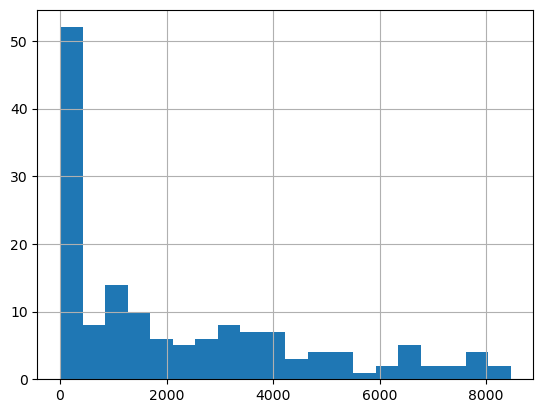

In [68]:
df['Migration distance'].hist(bins=20)

In [69]:
# check how many migration distance values are 0
(df['Migration distance'] == 0).sum()

41

While some birds do not migrate, you can keep things straightforward by adding a value of 1 to the migration distances of all birds, including those that do not migrate (You can drop such rows as well).

In [70]:
df['Migration distance'] = df['Migration distance'] + 1.
df.head()

,Species,Migration distance,Body mass,Brain mass,Size of cerebellum,Size of telencephalon,Size of optic lobe,Wing aspect ratio,Wing area
0,Accipiter gentilis,543.0,1100.0,7.674,1.088,4.617,0.837,5.841,0.193
1,Accipiter nisus,2939.1,260.0,3.081,0.499,1.593,0.440,5.891,0.093
2,Acrocephalus scirpaceus,3578.0,14.0,0.483,0.066,0.282,0.070,4.835,0.008
3,Aegithalos caudatus,27.1,7.5,0.456,0.035,0.283,0.059,4.463,0.007
4,Aegypius monachus,973.2,9000.0,24.808,2.812,17.936,1.020,NaN,NaN


Use the remaining fields to predict the migration distance, update the dataframe as follows:

In [30]:
X = df.drop('Migration distance', axis=1)
y = df['Migration distance']

**Task 8 (1 point)**: Perform multilinear regression y ~ X (the dependent variable y is modeled as a function of the independent variable X). Plot the residuals and compute the rsquared value.
 What is your conclusion (max 2 line answer).

**Task 9 (1 point)**: A transformation of the inputs can lead to a better fit. Figure out the transform. Hint: Refer to the 
previous tutorial session.

## 2 Classification with logistic regression and linear discriminant analysis

### 2.1 Logistic regression
In the lecture you've learned about logistic regression, which is the appropriate tool when the dependent variable is dichotomous (binary). Apply this tool the iris flower dataset (https://en.wikipedia.org/wiki/Iris_flower_data_set) and see if you can classify flowers correctly.

The iris dataset is included in scikit-learn.

In [31]:
iris = datasets.load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

This function returns a dictionary that contains a bunch of different fields. All the data points are contained in 'data'. The four columns correspond to the following four features.

In [32]:
iris.data.shape

(150, 4)

In [33]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

For every data point, the respective class label is stored in target. There is a total of three classes.

In [34]:
iris.target.shape

(150,)

In [35]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [36]:
df = pd.DataFrame(iris.data)  # create a dataframe from the iris data
cols = [name for name in iris.feature_names]  # define the column names
df.columns = cols  # set the column names

In [37]:
# Add the species column as the target
df['species'] = iris.target  # add the species column

**Task 10 (1 point)**: Plot pair-wise relationships of a dataset. 

To perform binary classification, you discard all data points belonging to a certain class. For example, selecting all the rows that do not belong to that class. Here, you can drop the class 'virginica'.

In [38]:
idcs = iris.target != 2  # get all the indices where the class is not 2
data = iris.data[idcs].astype(np.float32)
target = iris.target[idcs]

In [39]:
X = data[:, 3:]
y = target

**Task 11 (1 point)**: Fit a logistic regression model where the dependent variable y is modeled as a function of the independent variable X and predict target classes.

**Task 12 (1 point)**: Compute the accuracy of the model

### 2.2 Linear Discriminant Analysis (LDA)
Keep working with the iris dataset from the last exercise, using the built-in classifier in scikit-learn.

- Try to explain in your own words how LDA works. What is the main theorem it uses and what are the assumptions?
- Use the *discriminant_analysis.LinearDiscriminantAnalysis* classifier from scikit-learn on the (full) iris dataset to predict the flower species as a function of sepal/petal length.
- Challenge: (1) Visualize and quantify how well the classifier works; (2) Use different symbols for correct/incorrect classifications; (3) Plot the decision boundaries.

Start with a scatter plot where the colors indicate the species.

<Axes: xlabel='sepal length (cm)', ylabel='petal length (cm)'>

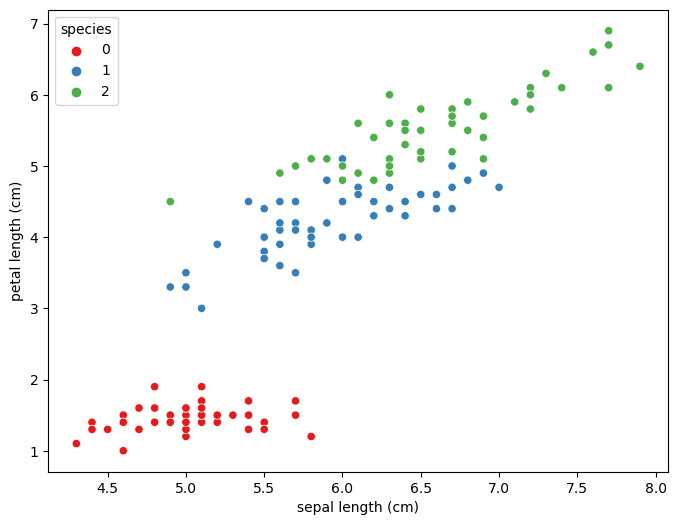

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=df, x='sepal length (cm)', y='petal length (cm)',
                hue='species',  palette='Set1')

In [43]:
# Define set of variables
X = df[['sepal length (cm)', 'petal length (cm)']]
y = iris.target

Use the LDA model [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

**Task 13 (1 point)**: Fit the LDA Model

Mean accuracy: 0.97


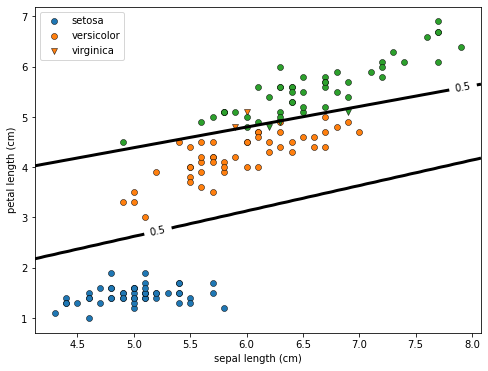

In [ ]:
# note: don't worry if you don't understand everything here
# but if you're interested, please ask!
from matplotlib import cm
cmap = cm.get_cmap('tab10')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
y_pred = lda.predict(X) # predict the class
tp = (y == y_pred)  # true positive

X = np.asarray(X)

# true positives for each class
tp0, tp1, tp2 = tp[y == 0], tp[y == 1], tp[y == 2]

# split features into corresponding classes
X0, X1, X2 = X[y == 0], X[y == 1], X[y == 2]

# split features into true/false positives
X0_tp, X0_fp = X0[tp0], X0[~tp0] # note: ~tp0 means negation of tp0
X1_tp, X1_fp = X1[tp1], X1[~tp1]
X2_tp, X2_fp = X2[tp2], X2[~tp2]

## scatter plot for 3 classes
# scatter plot for class 0
sns.scatterplot(x=X0_tp[:, 0], y=X0_tp[:, 1], color=cmap(0), edgecolor='k') # scatterplot for true positives
sns.scatterplot(x=X0_fp[:, 0], y=X0_fp[:, 1], marker='v', color=cmap(0),
                edgecolor='k') # scatterplot for false positives

# scatter plot for class 1
sns.scatterplot(x=X1_tp[:, 0], y=X1_tp[:, 1], color=cmap(1), edgecolor='k')
sns.scatterplot(x=X1_fp[:, 0], y=X1_fp[:, 1], marker='v', color=cmap(1),
                edgecolor='k')

# scatter plot for class 2
sns.scatterplot(x=X2_tp[:, 0], y=X2_tp[:, 1], color=cmap(2), edgecolor='k')
sns.scatterplot(x=X2_fp[:, 0], y=X2_fp[:, 1], marker='v', color=cmap(2),
                edgecolor='k')

## decision boundaries
# draw them at the 50% probability level
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
# see https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html
# ravel returns a contiguous flattened array
Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()]) # predict the class probabilities of each data point in the mesh grid
Z = Z[:, 1].reshape(xx.shape) # only get the probability of class 1
cs = ax.contour(xx, yy, Z, [0.5], linewidths=3, colors='black')
ax.clabel(cs, cs.levels, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('petal length (cm)')

# add legend for each class
ax.legend(['TP for class 0', 'TP for class 1', 'FP for class 1','TP for class 2', 'FP for class 2'], loc='upper left')

print('Mean accuracy: {:.2f}'.format(lda.score(X, y)))